In [2]:
%matplotlib inline 
import pickle
import numpy as np 
import mdtraj as md 
import pyemma as py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.5, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="2" 

In [4]:
os.environ['PYEMMA_NJOBS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

In [5]:
from hde import HDE

Using TensorFlow backend.


In [6]:
%load_ext autoreload 
%autoreload 2

In [7]:
import tensorflow as tf
import keras.backend as K
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [8]:
tica_viz = py.load('tica_viz.mdl')
hde = pickle.load(open('hde-model-scan/hde_model_078.pkl', 'rb'))
X = np.load('scaled_features.npy')
Z = hde.transform(X)
W = tica_viz.transform(X)

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
trj_dir = "/home/hsidky/Data/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein"
trj_file = os.path.join(trj_dir, "trp-cage_rmsdmin.dcd")
pdb_file = os.path.join(trj_dir, "2JOF-0-protein.pdb")

In [10]:
traj = md.load(trj_file, top=pdb_file)

## Visualization

In [24]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [25]:
def update_plots(i, idx, l1, l2, l3):
    l1.set_offsets([W[idx[i], 0], W[idx[i], 2]])
    l2.set_offsets([W[idx[i], 0], W[idx[i], 2]])
    l3.set_array(plt.imread('frames/final.untitled.{:05d}.jpg'.format(i))[50:-50, 50:-50])
    return l1, l2, l3

In [26]:
idx = list(range(99000, 101000, 10))

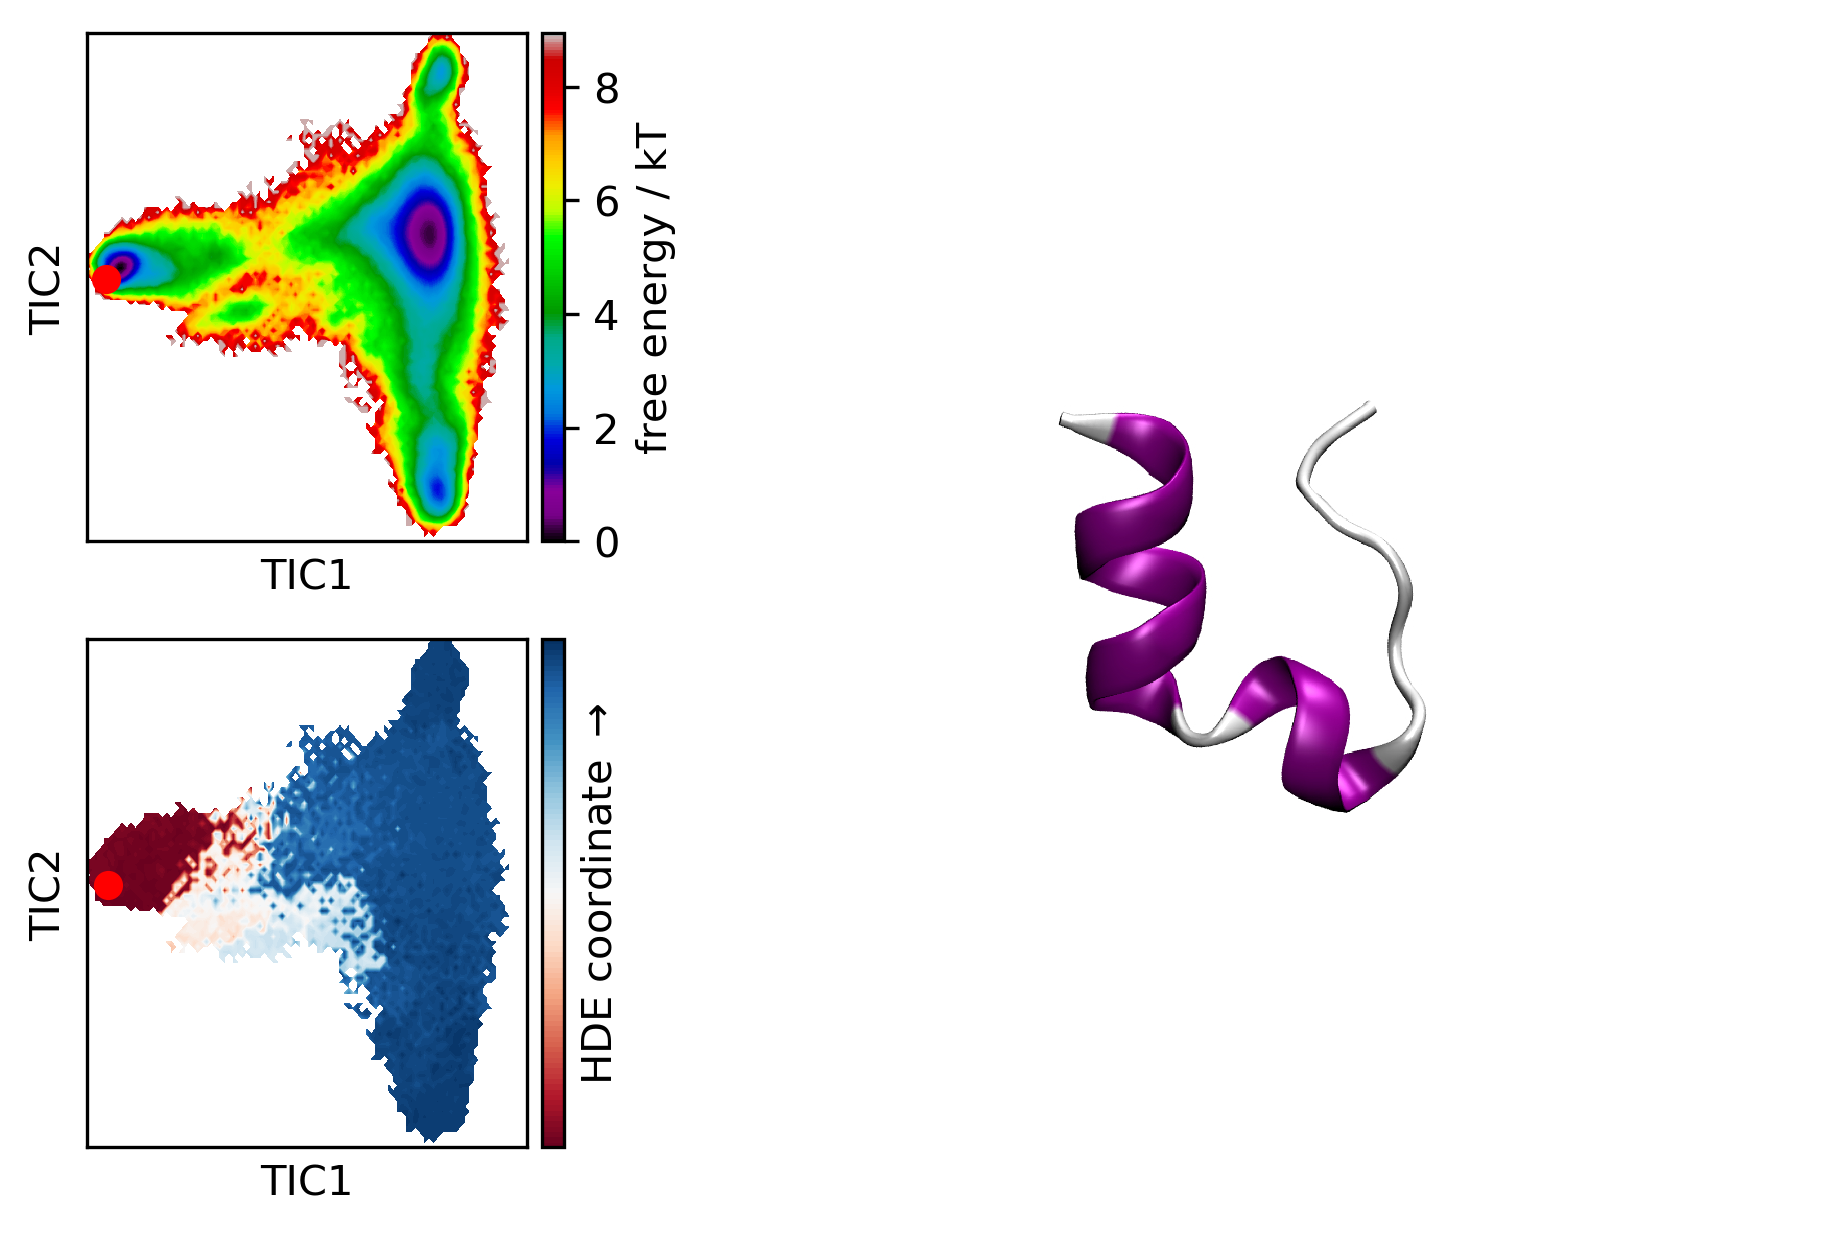

In [27]:
fig = plt.figure(constrained_layout=True, dpi=300)

gs = plt.GridSpec(2, 10, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)

_, _, misc = py.plots.plot_free_energy(W[:,0], W[:,2], ax=ax1, cax=cax, levels=np.arange(0, 9, 0.05), legacy=False)
ax1.set_xlabel(r'TIC1')
ax1.set_ylabel(r'TIC2')
ax1.set_xticks([])
ax1.set_yticks([])
misc['cbar'].set_ticks([np.arange(0, 10, 2)])
misc['cbar'].set_label(r'free energy / kT')

l1 = ax1.scatter([], [], c='red', animated=True)

ax2 = fig.add_subplot(gs[1, :3])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)

_, _, misc = py.plots.plot_contour(W[:,0], W[:,2], Z[:, 0], mask=True, cmap='RdBu', ax=ax2, cax=cax)
ax2.set_xlabel(r'TIC1')
ax2.set_ylabel(r'TIC2')
ax2.set_xticks([])
ax2.set_yticks([])
misc['cbar'].set_ticks([])
misc['cbar'].set_label(r'HDE coordinate $\rightarrow$')

l2 = ax2.scatter([], [], c='red', animated=True)

ax3 = fig.add_subplot(gs[:, 3:])
l3 = ax3.imshow(plt.imread('frames/final.untitled.00001.jpg')[50:-50, 50:-50])
ax3.axis('off');

#update_plots(299, idx, l1, l2, ax3)

line_ani = animation.FuncAnimation(fig, update_plots, len(idx), fargs=(idx, l1, l2, l3),
                                    interval=50, blit=True)
line_ani.save('animation.mp4', writer=writer)
#plt.savefig('test.png', dpi=300)

In [ ]:
h